In [1]:
from micrograd.engine import Value

In [2]:
# a = Value(-4.0)
# b = Value(2.0)
# c = a + b
# d = a * b + b**3
# c += c + 1
# c += 1 + c + (-a)
# d += d * 2 + (b + a).relu()
# d += 3 * d + (b - a).relu()
# e = c - d
# f = e**2
# g = f / 2.0
# g += 10.0 / f

In [3]:
import math
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

In [4]:
def f(x):
    return 3 * x ** 2 - 4 * x + 5

In [5]:
f(3.0)

20.0

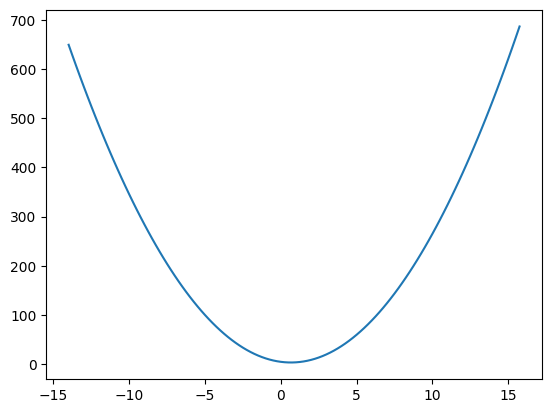

In [6]:
xs = np.arange(-14, 16, 0.25)
ys = f(xs)
plt.plot(xs, ys)

In [7]:
h = 0.0001
x = 3.0
(f(x + h) - f(x)) / h

14.000300000063248

In [8]:
a = 2.0
b = -3.0
c = 10.0
d = a * b + c
print(d)

4.0


In [9]:
h = 0.0001

# inputs
a = 2.0
b = -3.0
c = 10.0

d1 = a * b + c
a += h
d2 = a * b + c

print('d1', d1)
print('d2', d2)
print('slope', (d2 - d1) / h)

d1 4.0
d2 3.999699999999999
slope -3.000000000010772


In [10]:
h = 0.0001

# inputs
a = 2.0
b = -3.0
c = 10.0

d1 = a * b + c
b += h
d2 = a * b + c

print('d1', d1)
print('d2', d2)
print('slope', (d2 - d1) / h)

d1 4.0
d2 4.0002
slope 2.0000000000042206


In [11]:
h = 0.0001

# inputs
a = 2.0
b = -3.0
c = 10.0

d1 = a * b + c
c += h
d2 = a * b + c

print('d1', d1)
print('d2', d2)
print('slope', (d2 - d1) / h)

d1 4.0
d2 4.0001
slope 0.9999999999976694


In [12]:
class Value:
    
    def __init__(self, data, _children=(), _op='', label=''):
        self.data = data
        self.grad = 0.0
        self._backward = lambda: None 
        self._prev = set(_children)
        self._op = _op
        self.label = label
        
    def __repr__(self):
        return f"Value(data={self.data})"
    
    def __add__(self, other):
        other = other if isinstance(other, Value) else Value(other)
        out = Value(self.data + other.data, (self, other), '+')
    
        def _backward():
            self.grad += 1.0 * out.grad
            other.grad += 1.0 * out.grad
        out._backward = _backward
        
        return out
    
    def __mul__(self, other):
        other = other if isinstance(other, Value) else Value(other)
        out = Value(self.data * other.data, (self, other), '*')
        
        def _backward():
            self.grad += other.data * out.grad
            other.grad += self.data * out.grad
        out._backward = _backward
        
        return out
    
    def __pow__(self, other):
        assert isinstance(other, (int, float)), "only supporting int/float powers for now"
        out = Value(self.data ** other, (self,), f'**{other}')
        
        def _backward():
            self.grad += other * self.data ** (other - 1) * out.grad
        out._backward = _backward
                    
        return out
                    
    
    def __rmul__(self, other):
        return self * other 
    
    def __truediv__(self, other):
        return self * other ** -1 
    
    def __neg__(self): #  - self
        return self * -1
    
    def __sub__(self, other): # self - other
        return self + (-other)    
    
    def __radd__(self, other): # other + self
        return self + other
    
    def tanh(self):
        x = self.data
        t = (math.exp(2 * x) - 1) / (math.exp(2*x) + 1)
        out = Value(t, (self,), 'tanh')
        
        def _backward():
            self.grad += (1 - t**2) * out.grad
        out._backward = _backward
        
        return out
    
    def exp(self):
        x = self.data
        out = Value(math.exp(x), (self, ), 'exp')
        
        def _backward():
            self.grad += out.data * out.grad
        out._backward = _backward
        
        return out
    
    def backward(self):
        
        topo = []
        visited = set()
        def built_topo(v):
            if v not in visited:
                visited.add(v)
                for child in v._prev:
                    built_topo(child)
                topo.append(v)
        built_topo(self)
        
        self.grad = 1.0
        for node in reversed(topo):
            node._backward()
    


In [13]:
# d._prev

In [14]:
# d._op

In [15]:

from graphviz import Digraph

def trace(root):
    # builds a set of all nodes and edges in graph
    nodes, edges = set(), set()
    def build(v):
        if v not in nodes:
            nodes.add(v)
            for child in v._prev:
                edges.add((child, v))
                build(child)
    build(root)
    return nodes, edges

def draw_dot(root):
    dot = Digraph(format='svg', graph_attr={'rankdir': 'LR'}) # LR - left to right
    
    nodes, edges = trace(root)
    for n in nodes:
        uid = str(id(n))
        # for any value in the graph, create a rectangular ('record') node for it
        dot.node(name = uid, label = "{ %s | data %.4f | grad %.4f }" % (n.label, n.data, n.grad), shape='record')
        if n._op:
            # if this value is a result of some operations, create an op node for it
            dot.node(name = uid + n._op, label = n._op)
            # and connect this node to it
            dot.edge(uid + n._op, uid)
            
    for n1, n2 in edges:
        # connect n1 to the op node of n2
        dot.edge(str(id(n1)), str(id(n2)) + n2._op)
        
    return dot

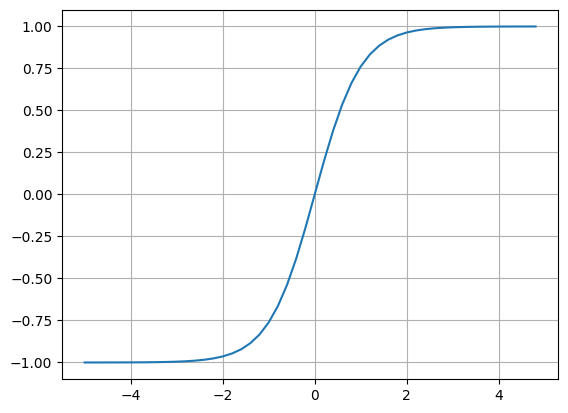

In [16]:
plt.plot(np.arange(-5, 5, 0.2), np.tanh(np.arange(-5, 5, 0.2))); plt.grid()

In [17]:
# inputs x1,x2
x1 = Value(2.0, label='x1')
x2 = Value(0.0, label='x2')
# weights w1,w2
w1 = Value(-3.0, label='w1')
w2 = Value(1.0, label='w2') 
# bias of the neuron
b = Value(6.8813735870195432, label='b')
# x1*w1 + x2*w2 + b
x1w1 = x1*w1; x1w1.label = 'x1*w1'
x2w2 = x2*w2; x2w2.label = 'x2*w2'
x1w1x2w2 = x1w1 + x2w2; x1w1x2w2.label = 'x1*w1 + x2*w2'
n = x1w1x2w2 + b; n.label = 'n'
o = n.tanh(); o.label = 'o'
o.backward()

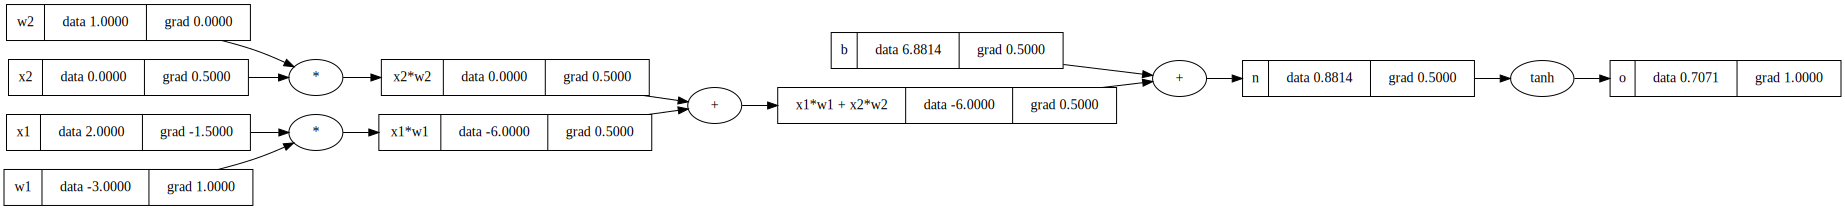

In [18]:
draw_dot(o)

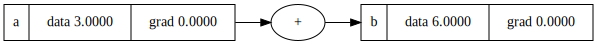

In [19]:
a = Value(3.0, label='a')
b = a + a; b.label='b'
b._backward()
draw_dot(b)

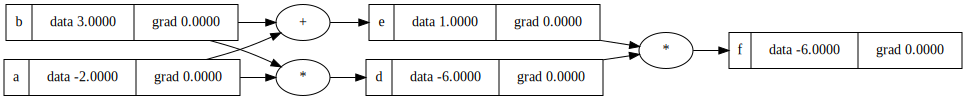

In [20]:
a = Value(-2.0, label='a')
b = Value(3.0, label='b')
d = a * b; d.label='d'
e = a + b; e.label='e'
f = d * e; f.label='f'

f._backward()

draw_dot(f)

In [21]:
a = Value(2.0)
b = Value(4.0)
a - b

Value(data=-2.0)

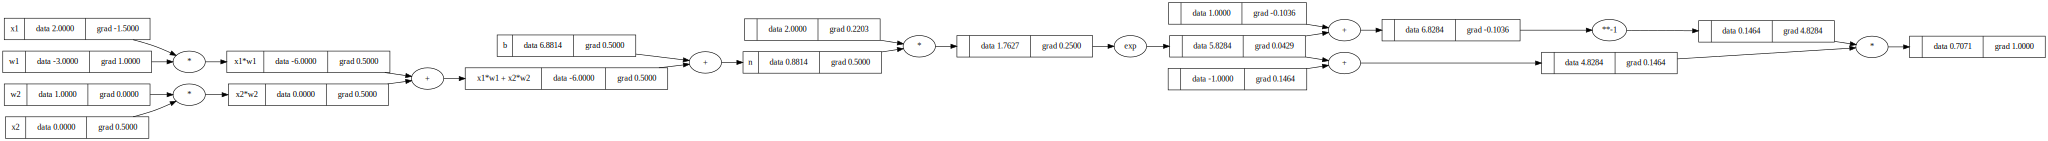

In [22]:
# inputs x1,x2
x1 = Value(2.0, label='x1')
x2 = Value(0.0, label='x2')
# weights w1,w2
w1 = Value(-3.0, label='w1')
w2 = Value(1.0, label='w2')
# bias of the neuron
b = Value(6.8813735870195432, label='b')
# x1*w1 + x2*w2 + b
x1w1 = x1*w1; x1w1.label = 'x1*w1'
x2w2 = x2*w2; x2w2.label = 'x2*w2'
x1w1x2w2 = x1w1 + x2w2; x1w1x2w2.label = 'x1*w1 + x2*w2'
n = x1w1x2w2 + b; n.label = 'n'
#
e = (2 * n).exp()
o = (e - 1) / (e + 1)
#

o.backward()
draw_dot(o)

In [23]:
import torch

/home/robb/Desktop/PROJEKTY/nn/Machine Learning With PyTorch and Scikit-Learn/RaschkaMLbook/lib/python3.9/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [24]:
x1 = torch.Tensor([2.0]).double()                ; x1.requires_grad = True
x2 = torch.Tensor([0.0]).double()                ; x2.requires_grad = True
w1 = torch.Tensor([-3.0]).double()               ; w1.requires_grad = True
w2 = torch.Tensor([1.0]).double()                ; w2.requires_grad = True
b = torch.Tensor([6.8813735870195432]).double()  ; b.requires_grad = True
n = x1*w1 + x2*w2 + b
o = torch.tanh(n)

print(o.data.item())
o.backward()

print('---')
print('x2', x2.grad.item())
print('w2', w2.grad.item())
print('x1', x1.grad.item())
print('w1', w1.grad.item())



0.7071066904050358
---
x2 0.5000001283844369
w2 0.0
x1 -1.5000003851533106
w1 1.0000002567688737


In [35]:
import random


class Neuron:
    
    def __init__(self, nin):
        self.w = [Value(random.uniform(-1, 1)) for _ in range(nin)]
        self.b = Value(random.uniform(-1, 1))
        
    def __call__(self, x):
        # w * x + b
        act = sum((wi * xi for wi, xi in zip(self.w, x)), self.b)
        out = act.tanh()
        return out
    
    def parameters(self):
        return self.w + [self.b]
    
    
class Layer:
    
    def __init__(self, nin, nout):
        self.neurons = [Neuron(nin) for _ in range(nout)]
    
    def __call__(self, x):
        outs = [n(x) for n in self.neurons]
        return outs[0] if len(outs) == 1 else outs
    
    def parameters(self):
        return [p for neuron in self.neurons for p in neuron.parameters()]
        
        
class MLP:
  
    def __init__(self, nin, nouts):
        sz = [nin] + nouts
        self.layers = [Layer(sz[i], sz[i+1]) for i in range(len(nouts))]

    def __call__(self, x):
        for layer in self.layers:
            x = layer(x)
        return x
    
    def parameters(self):
        return [p for layer in self.layers for p in layer.parameters()]

    


In [36]:
x = [2.0, 3.0, -1]
n = MLP(3, [4, 4, 1])
n(x)

Value(data=0.3774054014537411)

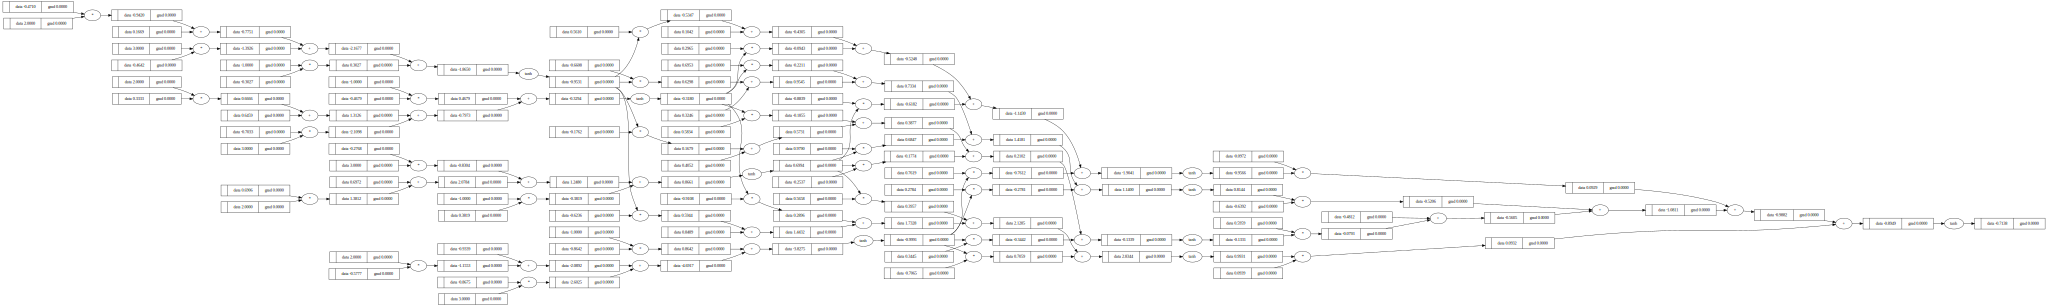

In [27]:
draw_dot(n(x))

In [37]:
xs = [
  [2.0, 3.0, -1.0],
  [3.0, -1.0, 0.5],
  [0.5, 1.0, 1.0],
  [1.0, 1.0, -1.0],
]

ys = [1.0, -1.0, -1.0, 1.0] # desired targets


In [38]:
ypred = [n(x) for x in xs]
loss = sum((yout - ygt) ** 2 for ygt, yout in zip(ys, ypred))
loss

Value(data=6.151278891741667)

In [62]:

for k in range(20):
    
    # forward pass
    ypred = [n(x) for x in xs]
    loss = sum((yout - ygt) ** 2 for ygt, yout in zip(ys, ypred))
    
    
    # backward pass
    for p in n.parameters():
        p.grad = 0.0
    loss.backward()
    
    
    # update()
    for p in n.parameters():
        p.data += -0.1 * p.grad
        
    print(k, loss.data)


0 0.0009849464444735348
1 0.0009804766729128445
2 0.0009760460512955106
3 0.0009716540731701719
4 0.0009673002407306005
5 0.0009629840646326861
6 0.0009587050638161102
7 0.0009544627653304641
8 0.0009502567041657906
9 0.0009460864230872198
10 0.000941951472473831
11 0.0009378514101614063
12 0.0009337858012891242
13 0.0009297542181499199
14 0.0009257562400446348
15 0.0009217914531395571
16 0.0009178594503275387
17 0.0009139598310923631
18 0.0009100922013764515
19 0.0009062561734517037


In [63]:
ypred

[Value(data=0.9879524722163598),
 Value(data=-0.9901265542673261),
 Value(data=-0.9825660724780018),
 Value(data=0.9810345975978421)]